## Applying Fine-Tuned DistilBERT Model on Full Yelp Review Data

### 0. Set-up and Imports

In [ ]:
import os
import re
import string
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from tqdm import tqdm
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from wordcloud import WordCloud
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jessting/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### 1. Inference on Full Dataset
- Model and Tokenizer Loading: Load both the fine-tuned model and baseline model for comparison
- Review Text Augmentation: Add contextual tokens (e.g., [PRE_2020], [USEFUL]) to raw review text using structured metadata
- Model Inference: Generate predicted sentiment probabilities using both the fine-tuned and baseline models

In [ ]:
# Load Model, Tokenizer, and Data
model_path = './yelp_finetuned_distilbert'
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path).to(device)
model.eval()
df = pd.read_csv('reviews_working.csv', index_col=0)

# Augment Text with Metadata
def clean_text(text):
    special_tokens = re.findall(r'\[.*?\]', text)
    cleaned = re.sub(r'[^a-zA-Z\s]', '', text)
    for token in special_tokens:
        cleaned = cleaned.replace(token.strip('[]'), '').strip() + f' {token}'
    return cleaned.strip()

def augment_text(row):
    tokens = [
        '[PRE_2020]' if row['pre_2020'] else '[POST_2020]',
        '[USEFUL]' if row['engagement_useful'] else '[NOT_USEFUL]',
        '[FUNNY]' if row['engagement_funny'] else '[NOT_FUNNY]',
        '[COOL]' if row['engagement_cool'] else '[NOT_COOL]',
        '[ESTABLISHED]' if row['established'] else '[NEW_BUSINESS]',
        '[HIGH_STABILITY]' if row['rating_stability'] < 0.5 else '[LOW_STABILITY]',
        f'[{row["state"]}]',
        clean_text(row['text'])
    ]
    return ' '.join(tokens)

df['augmented_text'] = df.apply(augment_text, axis=1)

# Fine-Tuned Model Predictions
batch_size = 16
ft_probs = []
for i in tqdm(range(0, len(df), batch_size), desc="Fine-Tuned Model Inference"):
    batch_texts = df['augmented_text'][i:i+batch_size].tolist()
    encodings = tokenizer(batch_texts, truncation=True, padding=True, return_tensors='pt', max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**encodings)
        probs = torch.softmax(outputs.logits, dim=1)[:, 1].cpu().numpy()
        ft_probs.extend(probs)
df['ft_prob'] = ft_probs

# Baseline Model Predictions
base_model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english').to(device)
base_tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english')
base_model.eval()
base_probs = []
for i in tqdm(range(0, len(df), batch_size), desc="Baseline Model Inference"):
    batch_texts = df['augmented_text'][i:i+batch_size].tolist()
    inputs = base_tokenizer(batch_texts, truncation=True, padding=True, return_tensors='pt', max_length=512).to(device)
    with torch.no_grad():
        outputs = base_model(**inputs)
        probs = torch.softmax(outputs.logits, dim=1)[:, 1].cpu().numpy()
        base_probs.extend(probs)
df['base_prob'] = base_probs

df['base_label'] = (df['base_prob'] > 0.5).astype(int)
df['ft_label'] = (df['ft_prob'] > 0.5).astype(int)
df['true_label'] = df['positive_review']
df['diff'] = np.abs(df['ft_prob'] - df['base_prob'])


Baseline Model Inference: 100%|██████████| 101603/101603 [7:26:40<00:00,  3.79it/s] 


### 2. Model-Level Results & Evaluation
- Performance Metrics: Compute Accuracy, Precision, Recall, and F1 scores for both models using true labels (i.e., 4+ stars)
- Comparison Plots: Visualize differences in model outputs with scatter plots, histograms, and confusion matrices

        Model  Accuracy  Precision    Recall        F1
0    Baseline  0.708648   0.936900  0.613229  0.741273
1  Fine-tuned  0.933038   0.944448  0.957961  0.951157


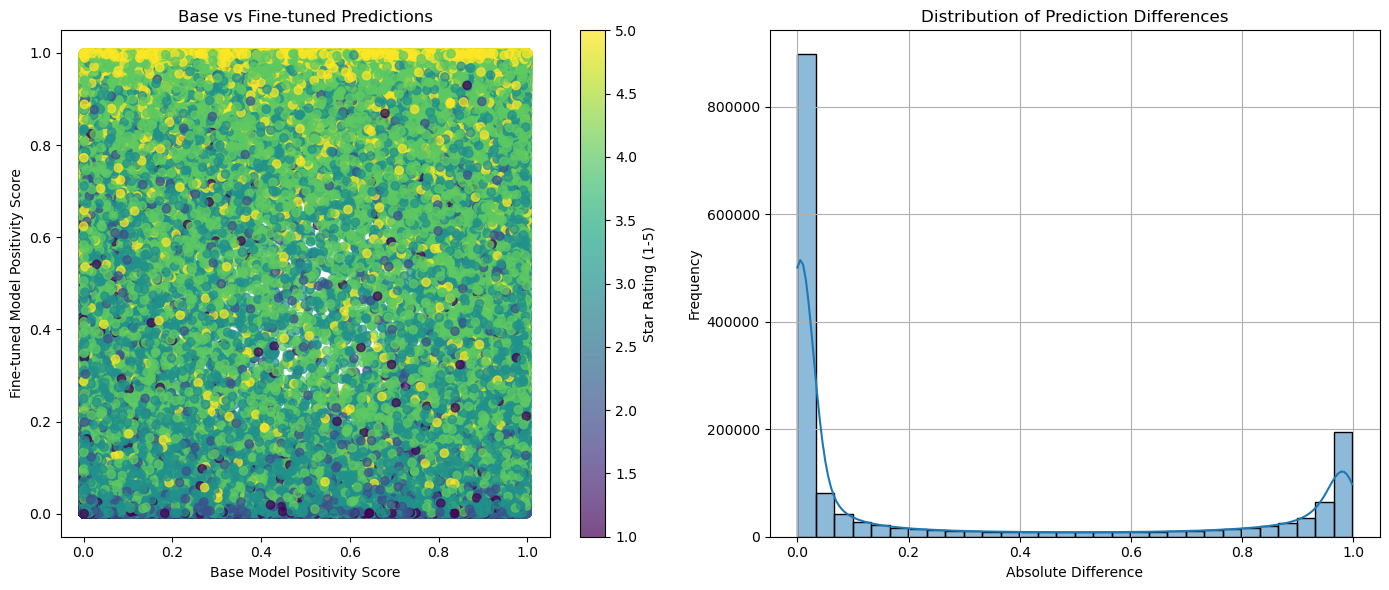

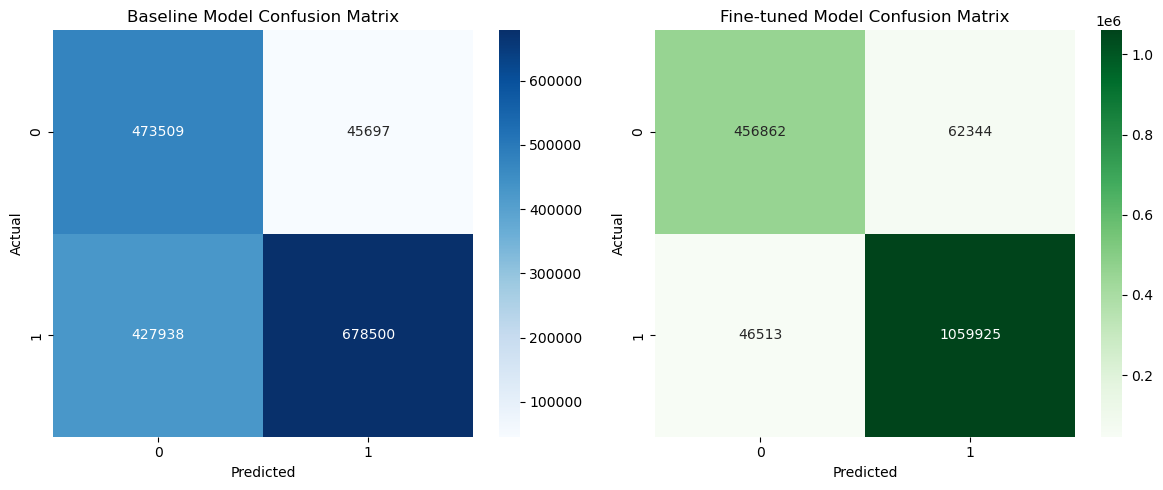

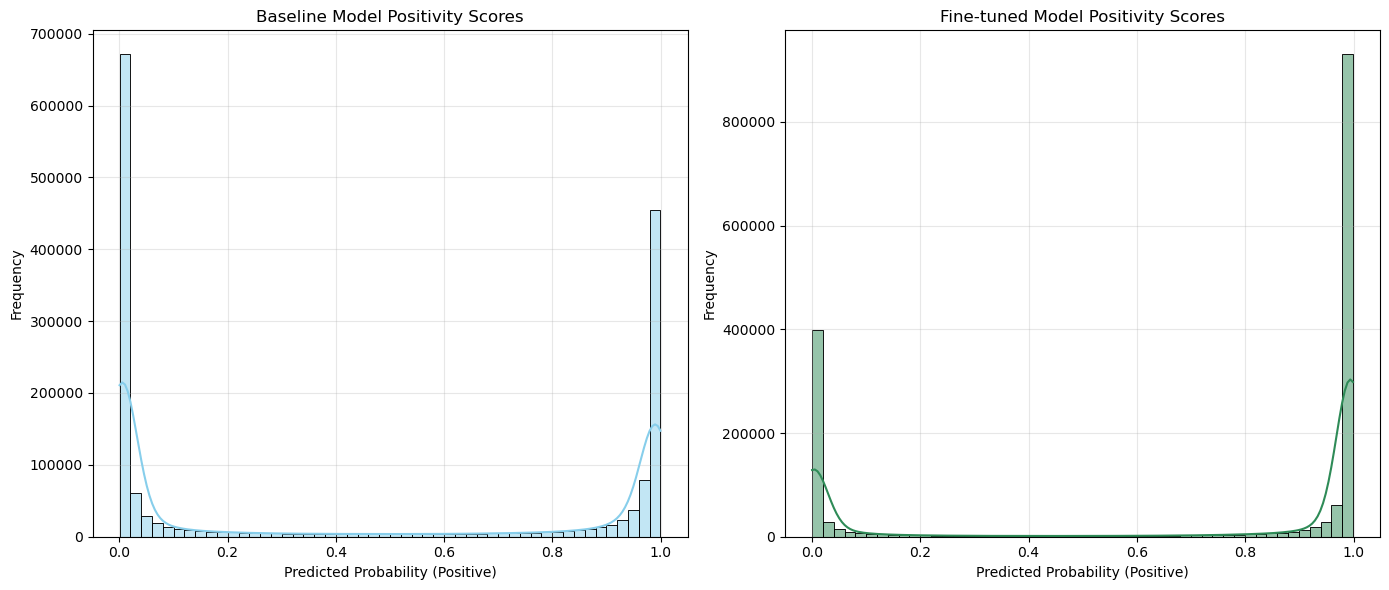

In [ ]:
# Metrics Calculation
metrics_df = pd.DataFrame({
    'Model': ['Baseline', 'Fine-tuned'],
    'Accuracy': [accuracy_score(df['true_label'], df['base_label']), accuracy_score(df['true_label'], df['ft_label'])],
    'Precision': [precision_score(df['true_label'], df['base_label']), precision_score(df['true_label'], df['ft_label'])],
    'Recall': [recall_score(df['true_label'], df['base_label']), recall_score(df['true_label'], df['ft_label'])],
    'F1': [f1_score(df['true_label'], df['base_label']), f1_score(df['true_label'], df['ft_label'])]
})
print(metrics_df)

# Comparing Predictions from Both Models
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
scatter = axs[0].scatter(df['base_prob'], df['ft_prob'], c=df['stars_review'], alpha=0.7, cmap='viridis')
axs[0].set_xlabel('Base Model Positivity Score')
axs[0].set_ylabel('Fine-tuned Model Positivity Score')
axs[0].set_title('Base vs Fine-tuned Predictions')
cbar = fig.colorbar(scatter, ax=axs[0])
cbar.set_label('Star Rating (1-5)')

sns.histplot(df['diff'], bins=30, kde=True, ax=axs[1])
axs[1].set_title('Distribution of Prediction Differences')
axs[1].set_xlabel('Absolute Difference')
axs[1].set_ylabel('Frequency')
axs[1].grid(True)
plt.tight_layout()
plt.show()

# Confusion Matrices
cm_base = confusion_matrix(df['true_label'], df['base_label'])
cm_ft = confusion_matrix(df['true_label'], df['ft_label'])
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(cm_base, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Baseline Model Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
sns.heatmap(cm_ft, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('Fine-tuned Model Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
plt.tight_layout()
plt.show()

# Distribution of Prediction Probabilities for Each Model
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
sns.histplot(df['base_prob'], bins=50, kde=True, ax=axs[0], color='skyblue')
axs[0].set_title('Baseline Model Positivity Scores')
axs[0].set_xlabel('Predicted Probability (Positive)')
axs[0].set_ylabel('Frequency')
axs[0].grid(alpha=0.3)
sns.histplot(df['ft_prob'], bins=50, kde=True, ax=axs[1], color='seagreen')
axs[1].set_title('Fine-tuned Model Positivity Scores')
axs[1].set_xlabel('Predicted Probability (Positive)')
axs[1].set_ylabel('Frequency')
axs[1].grid(alpha=0.3)
plt.tight_layout()
plt.show()

### 3. Review-Level Results
- Top Prediction Differences: Display reviews where the models most strongly disagree in predicted positivity.

In [6]:
# --- Top Differing Reviews ---
top_diff = df.sort_values('diff', ascending=False).head(20)
for i, row in top_diff.iterrows():
    print(f"\n{'='*80}")
    print(f"Review ID: {row['review_id']}")
    print(f"Star Rating: {row['stars_review']} ★")
    print(f"Baseline Positivity: {row['base_prob']:.4f} | Fine-tuned Positivity: {row['ft_prob']:.4f}")
    print(f"Tokens: {row['augmented_text'].split()[:10]}...")
    print(f"\nReview Text:\n{row['text']}")



Review ID: Rlm6LDrnROAxa66Q5Cc8jQ
Star Rating: 5.0 ★
Baseline Positivity: 0.0004 | Fine-tuned Positivity: 0.9988
Tokens: ['[POST_2020]', '[NOT_USEFUL]', '[NOT_FUNNY]', '[NOT_COOL]', '[ESTABLISHED]', '[HIGH_STABILITY]', '[TN]', 'Randomly', 'stumbled', 'across']...

Review Text:
Randomly stumbled across this Emmy's and OMG so glad we did. The pizza and Nashville Hot Katsu Chicken is to die for! Some of the best food we has in Nashville! Can't wait to come back!

Review ID: LsRdU54SFVwAoNMpHb31Dg
Star Rating: 3.0 ★
Baseline Positivity: 0.9987 | Fine-tuned Positivity: 0.0004
Tokens: ['[PRE_2020]', '[USEFUL]', '[FUNNY]', '[COOL]', '[ESTABLISHED]', '[LOW_STABILITY]', '[NV]', 'I', 'really', 'dont']...

Review Text:
I really don't know why so many people like this place soooo much...it was just OK for me. I wasn't impressed. They do give you quite a bit of food for the money. I had the pork carnitas with beans and rice. Friendly staff but just OK food.

Review ID: p1whEp7r0UIUtHIbwyTzbw
Star 

### 4. Thematic Analysis using TF-IDF and Word Clouds
- Preprocessing and Grouping: Clean review text and define review subgroups (e.g., by pre/post-COVID, business maturity, state)
- TF-IDF Extraction: Identify distinctive terms using average TF-IDF scores and frequency filters
- Word Cloud Generation: Generate and save word clouds visualizing key terms for each subgroup

In [ ]:
# TF-IDF Word Cloud
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['clean_text'] = df['text'].apply(preprocess_text).fillna('')
corpus = df['clean_text'].tolist()
nltk_stopwords = stopwords.words('english')
custom_stopwords = ['definitely','love','place','restaurant','best','delicious','amazing','good','great','food','back','like','get','would','got','also','one','really','even','much','many','could','us','go','went','going','always','never','every','well','still','may']
all_stopwords = list(set(nltk_stopwords + custom_stopwords))

# Group Definitions
groups = {}
if 'pre_2020' in df.columns:
    pre_df = df[df['pre_2020'] == True]
    post_df = df[df['pre_2020'] == False]
    groups['pre_2020_top'] = (df['pre_2020'] == True) & (df['ft_prob'] >= pre_df['ft_prob'].quantile(0.75))
    groups['post_2020_top'] = (df['pre_2020'] == False) & (df['ft_prob'] >= post_df['ft_prob'].quantile(0.75))
if 'established' in df.columns:
    established_df = df[df['established'] == True]
    new_df = df[df['established'] == False]
    groups['established_top'] = (df['established'] == True) & (df['ft_prob'] >= established_df['ft_prob'].quantile(0.75))
    groups['new_top'] = (df['established'] == False) & (df['ft_prob'] >= new_df['ft_prob'].quantile(0.75))
state_counts = df['state'].value_counts()
valid_states = state_counts[state_counts >= 100].index.tolist()
for state in valid_states:
    state_df = df[df['state'] == state]
    threshold = state_df['ft_prob'].quantile(0.70)
    groups[f'state_{state}_top'] = (df['state'] == state) & (df['ft_prob'] >= threshold)

# TF-IDF and Word Cloud Generation
os.makedirs("wordclouds_full", exist_ok=True)
tfidf = TfidfVectorizer(stop_words=all_stopwords, min_df=2, max_df=0.6, ngram_range=(1,3))
tfidf.fit(corpus)

results = []
wordcloud_data = {}

for name, condition in groups.items():
    try:
        group_docs = df[condition]['clean_text'].tolist()
        if len(group_docs) < 3:
            continue
        tfidf_matrix = tfidf.transform(group_docs)
        avg_tfidf = np.array(tfidf_matrix.mean(axis=0)).flatten()
        feature_names = tfidf.get_feature_names_out()
        top_indices = avg_tfidf.argsort()[::-1][:1000]
        top_terms = [(feature_names[i], avg_tfidf[i]) for i in top_indices]
        doc_counts = (tfidf_matrix > 0).sum(axis=0).A1
        group_size = len(group_docs)
        corpus_size = len(corpus)
        distinctive_terms = []
        for term, score in top_terms:
            term_idx = np.where(feature_names == term)[0][0]
            group_freq = doc_counts[term_idx]/group_size
            corpus_freq = doc_counts[term_idx]/corpus_size
            if (group_freq > 0.1) and (corpus_freq < 0.40):
                distinctive_terms.append((term, score))
        if len(distinctive_terms) < 50:
            distinctive_terms = top_terms[:50]
        for term, score in distinctive_terms[:50]:
            results.append({'category': name, 'term': term, 'score': score})
        wordcloud_data[name] = dict(distinctive_terms[:50])
        plt.figure(figsize=(10,5))
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(wordcloud_data[name])
        plt.imshow(wordcloud)
        plt.title(name)
        plt.axis("off")
        plt.savefig(f'wordclouds_full/wordcloud_{name}.png')
        plt.close()
    except Exception as e:
        print(f"Error processing {name}: {e}")

pd.DataFrame(results).to_csv('distinctive_terms_top_groups_full.csv', index=False)
print("Distinctive terms and wordclouds saved for full dataset.")


Distinctive terms and wordclouds saved for full dataset.


- Top/Bottom 20% Reviews: Analyze most and least positive reviews according to the fine-tuned model, visualize and save distinctive terms for overall sentiment extremes

In [ ]:
# Top/Bottom 20% Reviews
top_20_threshold = df['ft_prob'].quantile(0.80)
bottom_20_threshold = df['ft_prob'].quantile(0.20)
groups['overall_top20'] = df['ft_prob'] >= top_20_threshold
groups['overall_bottom20'] = df['ft_prob'] <= bottom_20_threshold

for name in ['overall_top20', 'overall_bottom20']:
    try:
        group_docs = df[groups[name]]['clean_text'].tolist()
        if len(group_docs) < 3:
            continue
        tfidf_matrix = tfidf.transform(group_docs)
        avg_tfidf = np.array(tfidf_matrix.mean(axis=0)).flatten()
        feature_names = tfidf.get_feature_names_out()
        top_indices = avg_tfidf.argsort()[::-1][:1000]
        top_terms = [(feature_names[i], avg_tfidf[i]) for i in top_indices]
        doc_counts = (tfidf_matrix > 0).sum(axis=0).A1
        group_size = len(group_docs)
        corpus_size = len(corpus)
        distinctive_terms = []
        for term, score in top_terms:
            term_idx = np.where(feature_names == term)[0][0]
            group_freq = doc_counts[term_idx] / group_size
            corpus_freq = doc_counts[term_idx] / corpus_size
            if (group_freq > 0.1) and (corpus_freq < 0.4):
                distinctive_terms.append((term, score))
        if len(distinctive_terms) < 50:
            distinctive_terms = top_terms[:50]
        wordcloud_data[name] = dict(distinctive_terms[:50])
        results.extend([{'category': name, 'term': term, 'score': score} for term, score in distinctive_terms[:50]])
        plt.figure(figsize=(10, 5))
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(wordcloud_data[name])
        plt.imshow(wordcloud)
        plt.title(name.replace('_', ' ').title())
        plt.axis("off")
        plt.savefig(f'wordclouds_full/wordcloud_{name}.png')
        plt.close()
    except Exception as e:
        print(f"Error processing {name}: {str(e)}")

# Save Distinctive Terms
pd.DataFrame(results).to_csv('distinctive_terms_top_groups_full.csv', index=False)
print("Updated distinctive terms saved to 'distinctive_terms_top_groups_full.csv'.")

# Save Full Dataset with Predictions
df.to_csv('full_yelp_predictions.csv', index=False)
print("Full dataset saved to 'full_yelp_predictions.csv'.")

Updated distinctive terms saved to 'distinctive_terms_top_groups_full.csv'.
Full dataset saved to 'full_yelp_predictions.csv'.
